In [ ]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


In [ ]:
def dice_accuracy(y_true, y_pred, epsilon=1e-7):
  num_classes = y_true.shape[-1]
  y_true = tf.cast(y_true, tf.float32)
  y_pred_class = tf.one_hot(tf.argmax(y_pred, axis=-1), num_classes)
  y_true = y_true[..., 1:] # excluding background
  y_pred_class = y_pred_class[..., 1:] # excluding background
  intersection = tf.reduce_sum(y_true * y_pred_class, axis=[1, 2])
  union = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred_class, axis=[1, 2])
  dice_scores = (2 * intersection + epsilon) / (union + epsilon)
  mean_dice = tf.reduce_mean(dice_scores)
  return mean_dice

In [ ]:
X_train = np.load('/content/drive/MyDrive/Veritas AI/Veritas AI - Micah/data/X_train.npy')
Y_train = np.load('/content/drive/MyDrive/Veritas AI/Veritas AI - Micah/data/Y_train.npy')
X_val = np.load('/content/drive/MyDrive/Veritas AI/Veritas AI - Micah/data/X_val.npy')
Y_val = np.load('/content/drive/MyDrive/Veritas AI/Veritas AI - Micah/data/Y_val.npy')

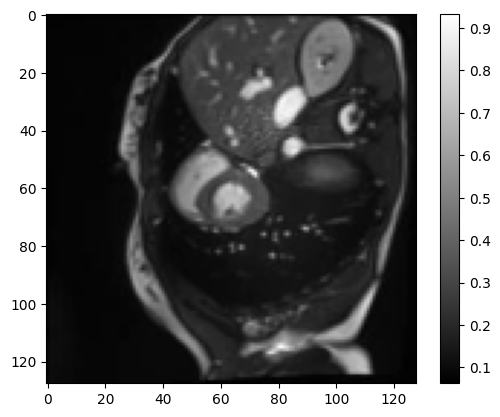

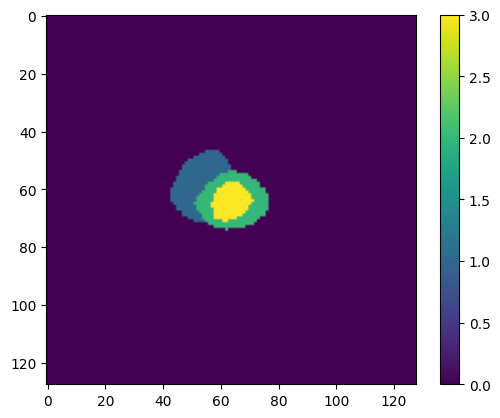

In [ ]:
k = 500
plt.figure()
plt.imshow(X_val[k, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(Y_val[k, :, :])
plt.colorbar()
plt.show()

In [ ]:
print(Y_train.shape)
print(Y_val.shape)
Y_train = np.eye(4)[Y_train.astype("int")]
Y_val = np.eye(4)[Y_val.astype("int")]
print(Y_train.shape)
print(Y_val.shape)

(1902, 128, 128)
(1076, 128, 128)
(1902, 128, 128, 4)
(1076, 128, 128, 4)


In [ ]:
#input_layer
input_layer = tf.keras.layers.Input(shape = (128, 128, 1))
#encoder path
#first level
x = tf.keras.layers.Conv2D(64, 3, activation = "relu", padding = "same")(input_layer)
x = tf.keras.layers.Conv2D(64, 3, activation = "relu", padding = "same")(x)
x = tf.keras.layers.MaxPooling2D()(x)
#second level
x = tf.keras.layers.Conv2D(128, 3, activation = "relu", padding = "same")(x)
x = tf.keras.layers.Conv2D(128, 3, activation = "relu", padding = "same")(x)
x = tf.keras.layers.MaxPooling2D()(x)
#third level
x = tf.keras.layers.Conv2D(256, 3, activation = "relu", padding = "same")(x)
x = tf.keras.layers.Conv2D(256, 3, activation = "relu", padding = "same")(x)
x = tf.keras.layers.MaxPooling2D()(x)
#decoder path
#bottle neck
x = tf.keras.layers.Conv2D(512, 3, activation = "relu", padding = "same")(x)
x = tf.keras.layers.Conv2D(512, 3, activation = "relu", padding = "same")(x)
x = tf.keras.layers.Conv2DTranspose(256, 2, strides = (2,2), activation = "relu", padding = "same")(x)
#third level
x = tf.keras.layers.Conv2D(256, 3, activation = "relu", padding = "same")(x)
x = tf.keras.layers.Conv2D(256, 3, activation = "relu", padding = "same")(x)
x = tf.keras.layers.Conv2DTranspose(128, 2, strides = (2,2), activation = "relu", padding = "same")(x)
#second level
x = tf.keras.layers.Conv2D(128, 3, activation = "relu", padding = "same")(x)
x = tf.keras.layers.Conv2D(128, 3, activation = "relu", padding = "same")(x)
x = tf.keras.layers.Conv2DTranspose(64, 2, strides = (2,2), activation = "relu", padding = "same")(x)
#first level
x = tf.keras.layers.Conv2D(64, 3, activation = "relu", padding = "same")(x)
x = tf.keras.layers.Conv2D(64, 3, activation = "relu", padding = "same")(x)
#output_layer
output_layer = tf.keras.layers.Conv2D(4, 1, activation = "softmax")(x)
#create the model
deconv_model = tf.keras.models.Model(inputs = input_layer, outputs = output_layer)

In [ ]:
deconv_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.CategoricalCrossentropy(), metrics = [dice_accuracy])
deconv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       147584    
                                                             

In [ ]:
deconv_history = deconv_model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs = 10, batch_size = 16)

Epoch 1/10
119/119 [==============================] - 38s 214ms/step - loss: 0.3013 - dice_accuracy: 0.0895 - val_loss: 0.1247 - val_dice_accuracy: 0.1176
Epoch 2/10
119/119 [==============================] - 17s 139ms/step - loss: 0.0969 - dice_accuracy: 0.1562 - val_loss: 0.0949 - val_dice_accuracy: 0.2528
Epoch 3/10
119/119 [==============================] - 17s 142ms/step - loss: 0.0715 - dice_accuracy: 0.3535 - val_loss: 0.0793 - val_dice_accuracy: 0.3872
Epoch 4/10
119/119 [==============================] - 17s 142ms/step - loss: 0.0560 - dice_accuracy: 0.4726 - val_loss: 0.0695 - val_dice_accuracy: 0.4413
Epoch 5/10
119/119 [==============================] - 17s 143ms/step - loss: 0.0434 - dice_accuracy: 0.5652 - val_loss: 0.0476 - val_dice_accuracy: 0.5829
Epoch 6/10
119/119 [==============================] - 17s 144ms/step - loss: 0.0345 - dice_accuracy: 0.6359 - val_loss: 0.0390 - val_dice_accuracy: 0.6207
Epoch 7/10
119/119 [==============================] - 20s 165ms/step -

In [ ]:
plt.figure()
plt.plot(deconv_history.history['loss'], label='training loss')
plt.plot(deconv_history.history['val_loss'], label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.figure()
plt.plot(deconv_history.history['dice_accuracy'], label='training DSC')
plt.plot(deconv_history.history['val_dice_accuracy'], label='validation DSC')
plt.xlabel('epochs')
plt.ylabel('DSC')
plt.legend()
plt.show()

NameError: name 'deconv_history' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
Y_pred = deconv_model.predict(X_val)

34/34 [==============================] - 8s 136ms/step


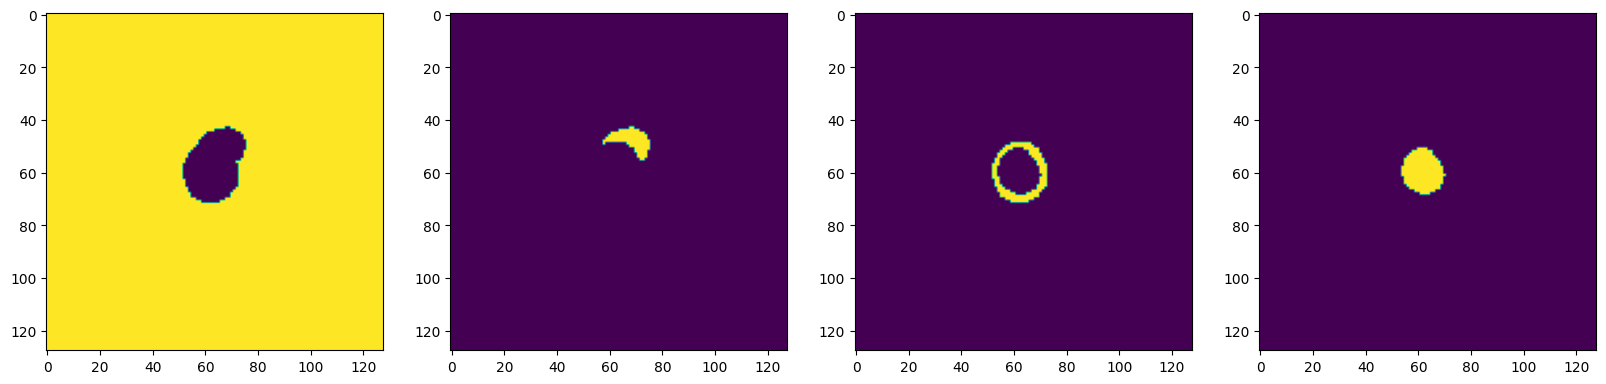

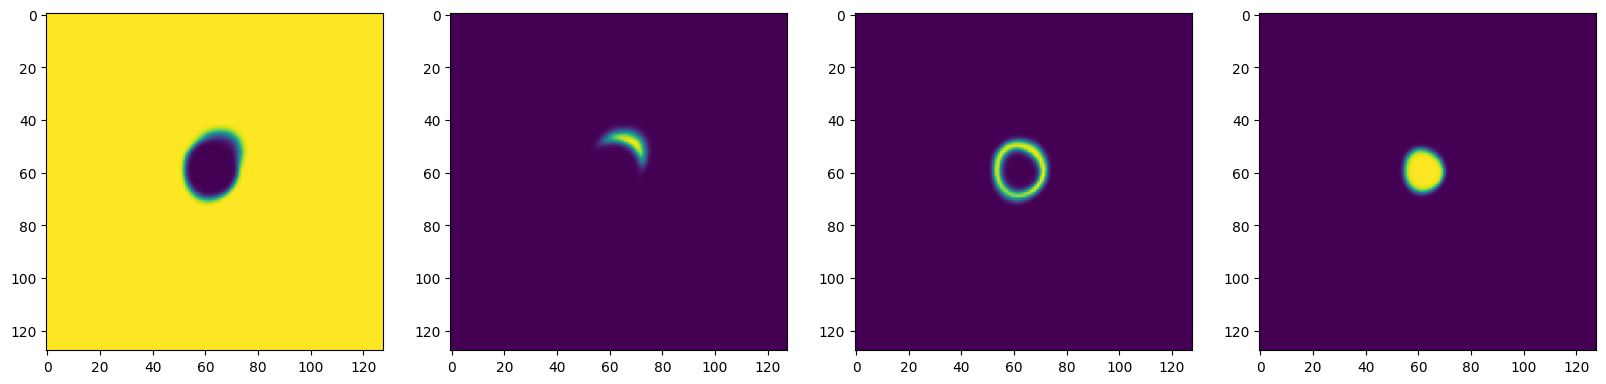

In [ ]:
plt.figure(figsize = (20, 80))
plt.subplot(1,4,1)
plt.imshow(Y_val[15,:, :, 0])
plt.subplot(1,4,2)
plt.imshow(Y_val[15,:, :, 1])
plt.subplot(1,4,3)
plt.imshow(Y_val[15,:, :, 2])
plt.subplot(1,4,4)
plt.imshow(Y_val[15,:, :, 3])
plt.show()

plt.figure(figsize = (20, 80))
plt.subplot(1,4,1)
plt.imshow(Y_pred[15,:, :, 0])
plt.subplot(1,4,2)
plt.imshow(Y_pred[15,:, :, 1])
plt.subplot(1,4,3)
plt.imshow(Y_pred[15,:, :, 2])
plt.subplot(1,4,4)
plt.imshow(Y_pred[15,:, :, 3])
plt.show()

In [ ]:
Y_val_0 = np.argmax(Y_val, axis = -1)
Y_pred_0 = np.argmax(Y_pred, axis = -1)

NameError: name 'Y_pred' is not defined

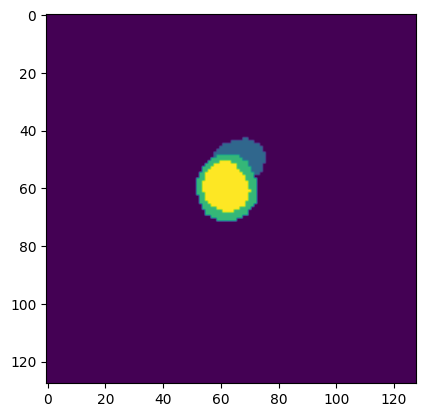

NameError: name 'Y_pred_0' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure()
plt.imshow(Y_val_0[15,:, :])
plt.show()

plt.figure()
plt.imshow(Y_pred_0[15, :, :])
plt.show()

In [ ]:
#input_layer
input_layer = tf.keras.layers.Input(shape = (128, 128, 1))
#encoder path
#first level
x = tf.keras.layers.Conv2D(64, 3, activation = "relu", padding = "same")(input_layer)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Conv2D(64, 3, activation = "relu", padding = "same")(x)
skip_1 = x
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.MaxPooling2D()(x)
# #second level
# x = tf.keras.layers.Conv2D(128, 3, activation = "relu", padding = "same")(x)
# x = tf.keras.layers.Dropout(0.25)(x)
# x = tf.keras.layers.Conv2D(128, 3, activation = "relu", padding = "same")(x)
# skip_2 = x
# x = tf.keras.layers.Dropout(0.25)(x)
# x = tf.keras.layers.MaxPooling2D()(x)
# #third level
# x = tf.keras.layers.Conv2D(256, 3, activation = "relu", padding = "same")(x)
# x = tf.keras.layers.Dropout(0.25)(x)
# x = tf.keras.layers.Conv2D(256, 3, activation = "relu", padding = "same")(x)
# skip_3 = x
# x = tf.keras.layers.Dropout(0.25)(x)
# x = tf.keras.layers.MaxPooling2D()(x)
# #fourth level
# x = tf.keras.layers.Conv2D(512, 3, activation = "relu", padding = "same")(x)
# x = tf.keras.layers.Dropout(0.25)(x)
# x = tf.keras.layers.Conv2D(512, 3, activation = "relu", padding = "same")(x)
# skip_4 = x
# x = tf.keras.layers.Dropout(0.25)(x)
# x = tf.keras.layers.MaxPooling2D()(x)
#decoder path
#bottle neck
x = tf.keras.layers.Conv2D(128, 3, activation = "relu", padding = "same")(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Conv2D(128, 3, activation = "relu", padding = "same")(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Conv2DTranspose(512, 2, strides = (2,2), activation = "relu", padding = "same")(x)
# #fourth level
# x = tf.keras.layers.concatenate([x, skip_4])
# x = tf.keras.layers.Conv2D(512, 3, activation = "relu", padding = "same")(x)
# x = tf.keras.layers.Dropout(0.25)(x)
# x = tf.keras.layers.Conv2D(512, 3, activation = "relu", padding = "same")(x)
# x = tf.keras.layers.Dropout(0.25)(x)
# x = tf.keras.layers.Conv2DTranspose(256, 2, strides = (2,2), activation = "relu", padding = "same")(x)
# #third level
# x = tf.keras.layers.concatenate([x, skip_3])
# x = tf.keras.layers.Conv2D(256, 3, activation = "relu", padding = "same")(x)
# x = tf.keras.layers.Dropout(0.25)(x)
# x = tf.keras.layers.Conv2D(256, 3, activation = "relu", padding = "same")(x)
# x = tf.keras.layers.Dropout(0.25)(x)
# x = tf.keras.layers.Conv2DTranspose(128, 2, strides = (2,2), activation = "relu", padding = "same")(x)
# #second level
# x = tf.keras.layers.concatenate([x, skip_2])
# x = tf.keras.layers.Conv2D(128, 3, activation = "relu", padding = "same")(x)
# x = tf.keras.layers.Dropout(0.25)(x)
# x = tf.keras.layers.Conv2D(128, 3, activation = "relu", padding = "same")(x)
# x = tf.keras.layers.Dropout(0.25)(x)
# x = tf.keras.layers.Conv2DTranspose(64, 2, strides = (2,2), activation = "relu", padding = "same")(x)
#first level
x = tf.keras.layers.concatenate([x, skip_1])
x = tf.keras.layers.Conv2D(64, 3, activation = "relu", padding = "same")(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Conv2D(64, 3, activation = "relu", padding = "same")(x)
x = tf.keras.layers.Dropout(0.25)(x)
#output_layer
output_layer = tf.keras.layers.Conv2D(4, 1, activation = "softmax")(x)
#create the model
unet_model = tf.keras.models.Model(inputs = input_layer, outputs = output_layer)

In [ ]:
unet_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.CategoricalCrossentropy(), metrics = [dice_accuracy])
unet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 64)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ dropout_1[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64, 128)    │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 128, 128, 512)  │        262,656 │ dropout_3[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128, 128, 576)  │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 64)   │        331,840 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 128, 128, 64)   │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 128, 128, 64)   │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 128, 128, 4)    │            260 │ dropout_5[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 890,692 (3.40 MB)

 Trainable params: 890,692 (3.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
unet_history = unet_model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs = 50, batch_size = 32)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 90s 932ms/step - dice_accuracy: 0.0740 - loss: 0.5091 - val_dice_accuracy: 0.1180 - val_loss: 0.1734
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 444ms/step - dice_accuracy: 0.0888 - loss: 0.1821 - val_dice_accuracy: 0.1180 - val_loss: 0.1796
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 453ms/step - dice_accuracy: 0.0924 - loss: 0.1770 - val_dice_accuracy: 0.1180 - val_loss: 0.1733
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 40s 444ms/step - dice_accuracy: 0.0961 - loss: 0.1733 - val_dice_accuracy: 0.1180 - val_loss: 0.1536
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 28s 471ms/step - dice_accuracy: 0.0923 - loss: 0.1657 - val_dice_accuracy: 0.1180 - val_loss: 0.1651
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 471ms/step - dice_accuracy: 0.0920 - loss: 0.1570 - val_dice_accuracy: 0.1180 - val_loss: 0.1365
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 29s 479ms/step - dice_accuracy: 0.0882 - loss: 0.1444 - val_dice_accuracy: 0.1180 - val_loss: 0.1280
Epoch 8/50
60/60 ━━━━━━━━━━

In [ ]:
unet_model.save("/content/drive/MyDrive/Veritas AI/Veritas AI - Micah/code/models/unet_level_1.h5")

NameError: name 'unet_model' is not defined

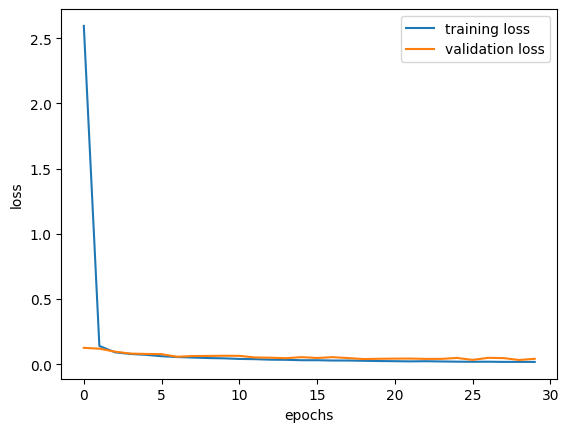

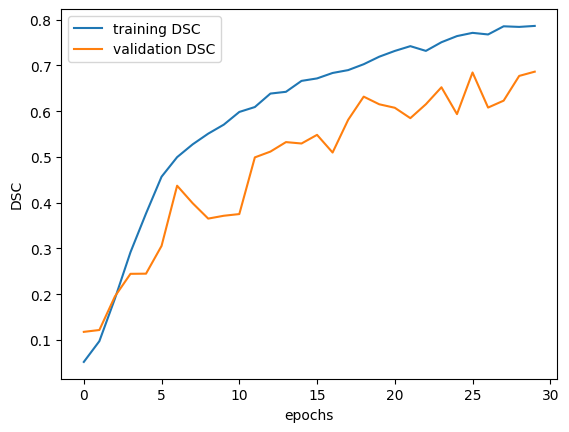

In [ ]:
plt.figure()
plt.plot(unet_history.history['loss'], label='training loss')
plt.plot(unet_history.history['val_loss'], label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.figure()
plt.plot(unet_history.history['dice_accuracy'], label='training DSC')
plt.plot(unet_history.history['val_dice_accuracy'], label='validation DSC')
plt.xlabel('epochs')
plt.ylabel('DSC')
plt.legend()
plt.show()

In [ ]:
Y_pred_2 = unet_model.predict(X_val)

34/34 [==============================] - 16s 269ms/step


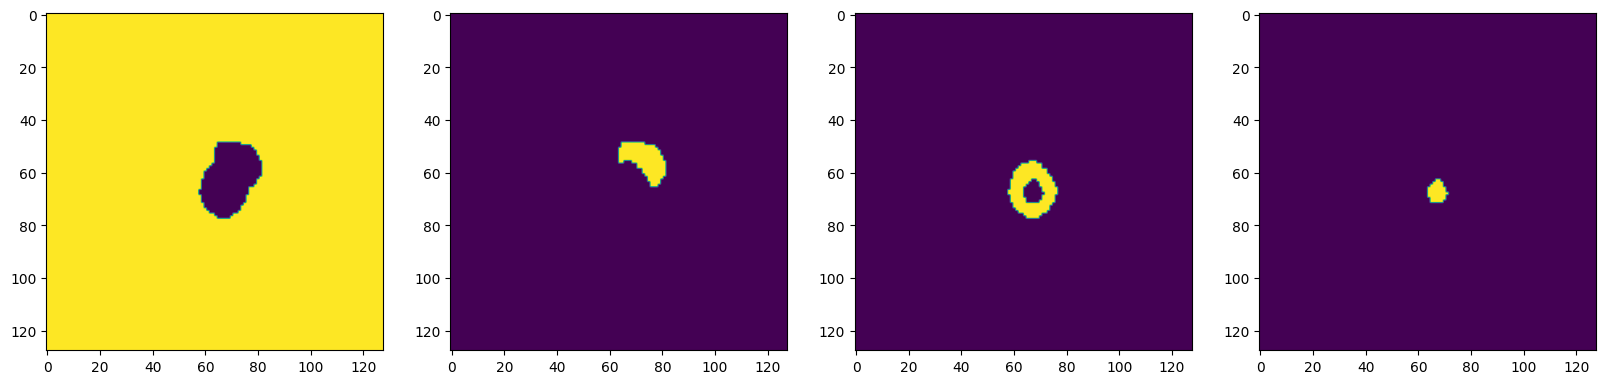

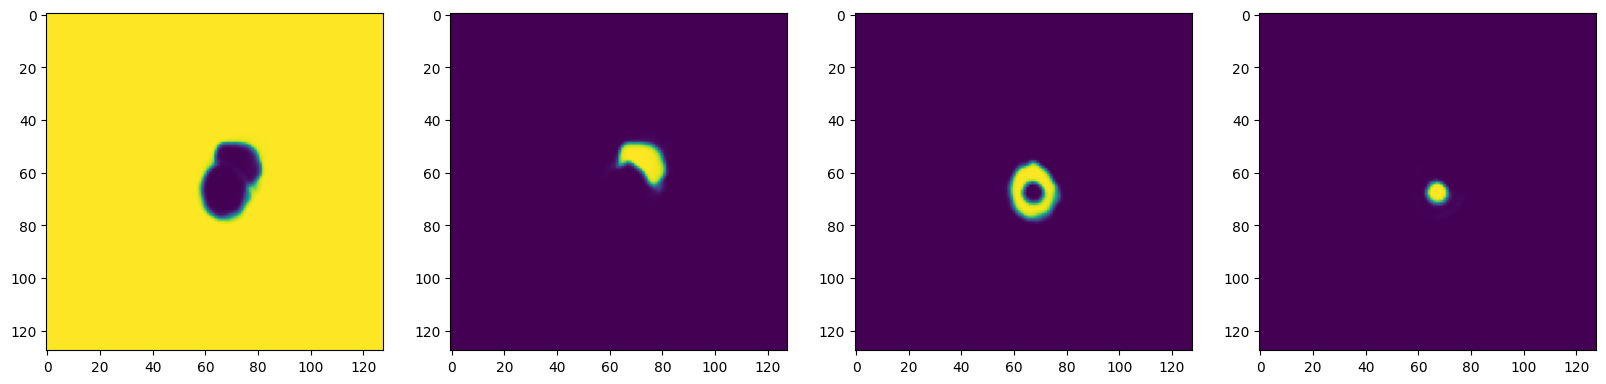

In [ ]:
plt.figure(figsize = (20, 80))
plt.subplot(1,4,1)
plt.imshow(Y_val[30,:, :, 0])
plt.subplot(1,4,2)
plt.imshow(Y_val[30,:, :, 1])
plt.subplot(1,4,3)
plt.imshow(Y_val[30,:, :, 2])
plt.subplot(1,4,4)
plt.imshow(Y_val[30,:, :, 3])
plt.show()

plt.figure(figsize = (20, 80))
plt.subplot(1,4,1)
plt.imshow(Y_pred_2[30,:, :, 0])
plt.subplot(1,4,2)
plt.imshow(Y_pred_2[30,:, :, 1])
plt.subplot(1,4,3)
plt.imshow(Y_pred_2[30,:, :, 2])
plt.subplot(1,4,4)
plt.imshow(Y_pred_2[30,:, :, 3])
plt.show()

In [ ]:
print(Y_pred_2[30, 60, 75, :])
print(np.argmax(Y_pred_2[30, 60, 75, :]))

IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

In [ ]:
Y_val_1 = np.argmax(Y_val, axis = -1)
Y_pred_2 = np.argmax(Y_pred_2, axis = -1)

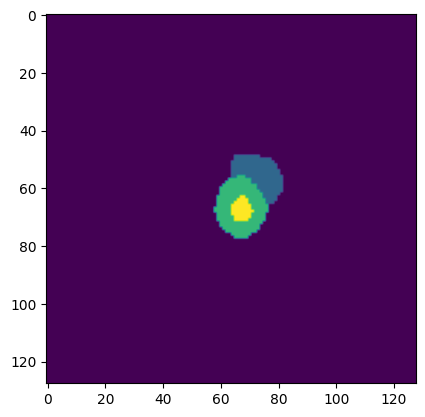

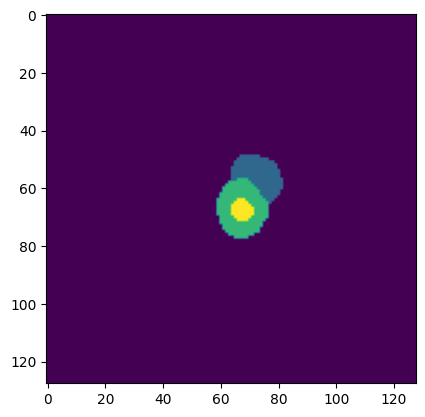

In [ ]:
plt.figure()
plt.imshow(Y_val_1[30,:, :])
plt.show()

plt.figure()
plt.imshow(Y_pred_2[30, :, :])
plt.show()